Toxicity Dataset : https://archive.ics.uci.edu/dataset/728/toxicity-2

The dataset includes 171 molecules designed for functional domains of a core clock protein, CRY1, responsible for generating circadian rhythm. 56 of the molecules are toxic and the rest are non-toxic. 

The data consists a complete set of 1203 molecular descriptors and needs feature selection before classification since some of the features are redundant. 

Introductory Paper:
Structure-based design and classifications of small molecules regulating the circadian rhythm period
By Seref Gul, F. Rahim, Safak Isin, Fatma Yilmaz, Nuri Ozturk, M. Turkay, I. Kavakli. 2021
https://www.semanticscholar.org/paper/Structure-based-design-and-classifications-of-small-Gul-Rahim/5944836c47bc7d1a2b0464a9a1db94d4bc7f28ce

# Imports and Configuration

In [20]:
pip install ucimlrepo

In [21]:
from __future__ import annotations

import warnings
from contextlib import contextmanager
from dataclasses import dataclass, field
from enum import Enum, auto
from functools import lru_cache
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from scipy import stats
from collections import Counter
import networkx as nx

from ucimlrepo import fetch_ucirepo
from sklearn.base import BaseEstimator, clone
from sklearn.model_selection import (
    train_test_split, StratifiedKFold,
    GridSearchCV, RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    precision_recall_curve, auc, roc_curve,
    matthews_corrcoef, average_precision_score,
    balanced_accuracy_score, make_scorer,
    brier_score_loss, log_loss
)
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier,
    GradientBoostingClassifier, ExtraTreesClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
)
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

from tqdm.auto import tqdm

In [22]:
# Configuration and Constants
@dataclass(frozen=True)
class Config:
    """Global configuration settings."""
    RANDOM_STATE: int = 42
    TEST_SIZE: float = 0.2
    INNER_CV: int = 5
    OUTER_CV: int = 5
    N_ITER_RANDOM_SEARCH: int = 20
    N_JOBS: int = -1
    MAX_ITER: int = 5000
    CORRELATION_THRESHOLD: float = 0.9
    VIF_THRESHOLD: float = 10.0
    
    # Visualization settings
    FIGURE_DPI: int = 300
    DEFAULT_FIGSIZE: Tuple[int, int] = (12, 8)
    
    # Output paths
    OUTPUT_DIR: Path = Path("outputs")


@dataclass(frozen=True)
class PlotStyle:
    """Consistent plot styling."""
    COLORS: Dict[str, str] = field(default_factory=lambda: {
        'linear': '#2E86AB',
        'nonlinear': '#A23B72',
        'valid': '#2bbbdf',
        'invalid': '#ff6b6b',
        'positive': 'green',
        'negative': 'red'
    })
    ALPHA: float = 0.7
    EDGE_COLOR: str = 'black'
    EDGE_WIDTH: float = 1.5


CONFIG = Config()
PLOT_STYLE = PlotStyle()

# Create output directory
CONFIG.OUTPUT_DIR.mkdir(exist_ok=True)


In [23]:
@contextmanager
def suppress_warnings():
    """Context manager for suppressing specific warnings."""
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        warnings.filterwarnings('ignore', category=FutureWarning)
        warnings.filterwarnings('ignore', category=ConvergenceWarning)
        yield


# Attempt to import ConvergenceWarning
try:
    from sklearn.exceptions import ConvergenceWarning
except ImportError:
    ConvergenceWarning = UserWarning

In [24]:
# Set up logging
def setup_logging(level: int = logging.INFO) -> logging.Logger:
    """Configure and return logger."""
    logging.basicConfig(
        level=level,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.StreamHandler(),
            logging.FileHandler(CONFIG.OUTPUT_DIR / 'pipeline.log')
        ]
    )
    return logging.getLogger(__name__)


logger = setup_logging()

In [25]:
# Visualization settings
def configure_plotting():
    """Set global matplotlib/seaborn settings."""
    sns.set_style("whitegrid")
    plt.rcParams.update({
        'figure.figsize': CONFIG.DEFAULT_FIGSIZE,
        'font.size': 11,
        'axes.titlesize': 13,
        'axes.labelsize': 11,
        'figure.dpi': 100,
        'savefig.dpi': CONFIG.FIGURE_DPI,
        'savefig.bbox': 'tight'
    })


configure_plotting()
np.random.seed(CONFIG.RANDOM_STATE)

# Data Classes and Enums

In [26]:
class ModelType(Enum):
    """Model type classification."""
    LINEAR = auto()
    NONLINEAR = auto()
    ENSEMBLE = auto()
    NEURAL_NETWORK = auto()
    DISCRIMINANT = auto()
    PROBABILISTIC = auto()


@dataclass
class ModelConfig:
    """Configuration for a single model."""
    name: str
    model: BaseEstimator
    model_type: ModelType
    param_grid: Optional[Dict[str, Any]] = None
    
    def __post_init__(self):
        if self.param_grid is None:
            self.param_grid = {}


@dataclass
class EvaluationMetrics:
    """Container for model evaluation metrics."""
    accuracy: float
    auc: float
    precision: float
    recall: float
    f1: float
    mcc: float
    pr_auc: float
    balanced_accuracy: float
    sensitivity: float
    specificity: float
    npv: float
    brier_score: Optional[float] = None
    log_loss_value: Optional[float] = None
    
    @classmethod
    def from_predictions(
        cls,
        y_true: np.ndarray,
        y_pred: np.ndarray,
        y_proba: Optional[np.ndarray] = None
    ) -> 'EvaluationMetrics':
        """Create metrics from predictions."""
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0
        
        if y_proba is None:
            y_proba = y_pred.astype(float)
        
        return cls(
            accuracy=accuracy_score(y_true, y_pred),
            auc=roc_auc_score(y_true, y_proba),
            precision=precision_score(y_true, y_pred, zero_division=0),
            recall=recall_score(y_true, y_pred, zero_division=0),
            f1=f1_score(y_true, y_pred, zero_division=0),
            mcc=matthews_corrcoef(y_true, y_pred),
            pr_auc=average_precision_score(y_true, y_proba),
            balanced_accuracy=balanced_accuracy_score(y_true, y_pred),
            sensitivity=sensitivity,
            specificity=specificity,
            npv=npv,
            brier_score=brier_score_loss(y_true, y_proba),
            log_loss_value=log_loss(y_true, y_proba, labels=[0, 1])
        )
    
    def to_dict(self) -> Dict[str, float]:
        """Convert to dictionary."""
        return {
            'accuracy': self.accuracy,
            'auc': self.auc,
            'precision': self.precision,
            'recall': self.recall,
            'f1': self.f1,
            'mcc': self.mcc,
            'pr_auc': self.pr_auc,
            'balanced_accuracy': self.balanced_accuracy,
            'sensitivity': self.sensitivity,
            'specificity': self.specificity,
            'npv': self.npv,
            'brier_score': self.brier_score,
            'log_loss': self.log_loss_value
        }


@dataclass
class CVResults:
    """Container for cross-validation results."""
    metrics: Dict[str, List[float]] = field(default_factory=dict)
    best_params: List[Dict] = field(default_factory=list)
    feature_importances: List[Optional[np.ndarray]] = field(default_factory=list)
    n_selected_features: List[int] = field(default_factory=list)
    fold_predictions: List[Dict] = field(default_factory=list)
    
    def __post_init__(self):
        metric_names = [
            'accuracy', 'auc', 'f1', 'mcc', 'pr_auc', 'bacc',
            'sensitivity', 'specificity', 'precision', 'brier', 'log_loss'
        ]
        for name in metric_names:
            if name not in self.metrics:
                self.metrics[name] = []
    
    def add_fold_metrics(self, metrics: EvaluationMetrics):
        """Add metrics from a single fold."""
        self.metrics['accuracy'].append(metrics.accuracy)
        self.metrics['auc'].append(metrics.auc)
        self.metrics['f1'].append(metrics.f1)
        self.metrics['mcc'].append(metrics.mcc)
        self.metrics['pr_auc'].append(metrics.pr_auc)
        self.metrics['bacc'].append(metrics.balanced_accuracy)
        self.metrics['sensitivity'].append(metrics.sensitivity)
        self.metrics['specificity'].append(metrics.specificity)
        self.metrics['precision'].append(metrics.precision)
        if metrics.brier_score is not None:
            self.metrics['brier'].append(metrics.brier_score)
        if metrics.log_loss_value is not None:
            self.metrics['log_loss'].append(metrics.log_loss_value)
    
    @property
    def is_empty(self) -> bool:
        return len(self.metrics.get('mcc', [])) == 0
    
    @property
    def n_completed_folds(self) -> int:
        return len(self.metrics.get('mcc', []))



# Data Loading and Preprocessing

In [27]:
class DataLoader:
    """Handles data loading and preprocessing."""
    
    def __init__(self, dataset_id: int = 728):
        self.dataset_id = dataset_id
        self.X: Optional[pd.DataFrame] = None
        self.y: Optional[pd.Series] = None
        self.feature_names: List[str] = []
        
    def load(self) -> Tuple[pd.DataFrame, pd.Series]:
        """Load and preprocess the dataset."""
        logger.info(f"Loading dataset {self.dataset_id}...")
        
        data = fetch_ucirepo(id=self.dataset_id)
        self.X = data.data.features
        y_raw = data.data.targets
        
        # Binary encoding: NonToxic=1, Toxic=0
        self.y = (y_raw['Class'] == 'NonToxic').astype(int)
        self.feature_names = self.X.columns.tolist()
        
        self._print_summary(y_raw)
        return self.X, self.y
    
    def _print_summary(self, y_raw: pd.DataFrame):
        """Print dataset summary."""
        print("=" * 80)
        print("DATASET OVERVIEW")
        print("=" * 80)
        print(f"Feature matrix shape: {self.X.shape}")
        print(f"Number of molecules (n): {self.X.shape[0]}")
        print(f"Number of descriptors (p): {self.X.shape[1]}")
        print(f"Dimensionality ratio (p/n): {self.X.shape[1]/self.X.shape[0]:.2f}")
        print(f"\nClass distribution:")
        print(y_raw['Class'].value_counts())
        print(f"\nMissing values in features: {self.X.isnull().sum().sum()}")
        print(f"Missing values in target: {self.y.isnull().sum()}")



In [28]:
class DataPreprocessor:
    """Handles train-test splitting and scaling."""
    
    def __init__(
        self,
        test_size: float = CONFIG.TEST_SIZE,
        random_state: int = CONFIG.RANDOM_STATE
    ):
        self.test_size = test_size
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.class_weights: Optional[Dict[int, float]] = None
        
    def prepare_data(
        self,
        X: pd.DataFrame,
        y: pd.Series,
        apply_smote: bool = False
    ) -> Dict[str, np.ndarray]:
        """Prepare data for modeling."""
        # Shuffle
        np.random.seed(self.random_state)
        shuffle_idx = np.random.permutation(len(X))
        X_shuffled = X.iloc[shuffle_idx].reset_index(drop=True)
        y_shuffled = y.iloc[shuffle_idx].reset_index(drop=True)
        
        # Split
        X_train, X_test, y_train, y_test = train_test_split(
            X_shuffled, y_shuffled,
            test_size=self.test_size,
            random_state=self.random_state,
            stratify=y_shuffled
        )
        
        # Scale
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Compute class weights
        self._compute_class_weights(y_train)
        
        result = {
            'X_train': X_train_scaled,
            'X_test': X_test_scaled,
            'y_train': y_train.values if hasattr(y_train, 'values') else y_train,
            'y_test': y_test.values if hasattr(y_test, 'values') else y_test,
        }
        
        if apply_smote:
            smote = SMOTE(random_state=self.random_state)
            X_train_smote, y_train_smote = smote.fit_resample(
                X_train_scaled, y_train
            )
            result['X_train_smote'] = X_train_smote
            result['y_train_smote'] = y_train_smote
            
        self._print_summary(result)
        return result
    
    def _compute_class_weights(self, y_train: np.ndarray):
        """Compute balanced class weights."""
        weights = compute_class_weight(
            'balanced',
            classes=np.unique(y_train),
            y=y_train
        )
        self.class_weights = {i: w for i, w in enumerate(weights)}
        
    def _print_summary(self, data: Dict[str, np.ndarray]):
        """Print preprocessing summary."""
        print("\n" + "=" * 80)
        print("DATA PREPROCESSING SUMMARY")
        print("=" * 80)
        print(f"Training set: {data['X_train'].shape}")
        print(f"Test set: {data['X_test'].shape}")
        print(f"\nTraining class distribution:")
        print(pd.Series(data['y_train']).value_counts())
        
        if 'X_train_smote' in data:
            print(f"\nSMOTE training set: {data['X_train_smote'].shape}")
            print(f"SMOTE class distribution:")
            print(pd.Series(data['y_train_smote']).value_counts())
            
        if self.class_weights:
            print(f"\nClass weights: {self.class_weights}")



# Multicollinearity Analysis

In [29]:
class MulticollinearityAnalyzer:
    """Analyzes multicollinearity in feature data."""
    
    def __init__(
        self,
        corr_threshold: float = CONFIG.CORRELATION_THRESHOLD,
        vif_threshold: float = CONFIG.VIF_THRESHOLD
    ):
        self.corr_threshold = corr_threshold
        self.vif_threshold = vif_threshold
        self.results: Dict[str, Any] = {}
        
    def analyze(self, X: pd.DataFrame) -> Dict[str, Any]:
        """Run comprehensive multicollinearity analysis."""
        print("=" * 80)
        print("MULTICOLLINEARITY DIAGNOSTICS")
        print("=" * 80)
        
        corr_matrix = X.corr()
        
        # Eigenvalue analysis
        self._analyze_eigenvalues(corr_matrix)
        
        # Pairwise correlations
        self._analyze_pairwise_correlations(corr_matrix)
        
        # VIF analysis
        self._analyze_vif(corr_matrix)
        
        # Visualization
        self._plot_diagnostics(corr_matrix)
        
        return self.results
    
    def _analyze_eigenvalues(self, corr_matrix: pd.DataFrame):
        """Analyze eigenvalue spectrum."""
        eigenvalues = np.linalg.eigvalsh(corr_matrix)
        condition_number = np.sqrt(
            eigenvalues.max() / (eigenvalues.min() + 1e-10)
        )
        effective_rank = np.sum(eigenvalues > 1e-5)
        
        self.results['eigenvalues'] = eigenvalues
        self.results['condition_number'] = condition_number
        self.results['effective_rank'] = effective_rank
        
        print(f"\n1. GLOBAL STABILITY ANALYSIS")
        print(f"   Condition Number: {condition_number:.2e}")
        print(f"   Effective Rank: {effective_rank}/{len(eigenvalues)}")
        
        if condition_number > 100:
            print("   ⚠ DIAGNOSIS: Severe multicollinearity detected")
    
    def _analyze_pairwise_correlations(self, corr_matrix: pd.DataFrame):
        """Analyze pairwise correlations using graph theory."""
        upper = corr_matrix.where(
            np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        )
        high_corr = upper.stack()
        high_corr = high_corr[high_corr.abs() > self.corr_threshold]
        
        # Build correlation graph
        G = nx.Graph()
        for (f1, f2), val in high_corr.items():
            G.add_edge(f1, f2, weight=val)
        
        components = list(nx.connected_components(G))
        
        self.results['high_corr_pairs'] = high_corr
        self.results['correlation_graph'] = G
        self.results['redundant_clusters'] = components
        
        print(f"\n2. PAIRWISE REDUNDANCY (|r| > {self.corr_threshold})")
        print(f"   Correlated pairs: {len(high_corr)}")
        print(f"   Redundant clusters: {len(components)}")
        
        if components:
            largest = max(components, key=len)
            print(f"   Largest cluster size: {len(largest)}")
    
    def _analyze_vif(self, corr_matrix: pd.DataFrame):
        """Calculate Variance Inflation Factors."""
        print(f"\n3. VIF ANALYSIS")
        
        try:
            inv_corr = np.linalg.inv(corr_matrix.values)
            vif_values = np.diag(inv_corr)
        except np.linalg.LinAlgError:
            logger.warning("Singular matrix - using pseudo-inverse")
            inv_corr = np.linalg.pinv(corr_matrix.values)
            vif_values = np.diag(inv_corr)
        
        vif_series = pd.Series(vif_values, index=corr_matrix.index)
        high_vif_count = (vif_series > self.vif_threshold).sum()
        
        self.results['vif'] = vif_series
        
        print(f"   Features with VIF > {self.vif_threshold}: "
              f"{high_vif_count}/{len(vif_series)}")
        print(f"   Mean VIF: {vif_series.mean():.2f}")
        print(f"   Max VIF: {vif_series.max():.2f} ({vif_series.idxmax()})")
    
    def _plot_diagnostics(self, corr_matrix: pd.DataFrame):
        """Create diagnostic visualizations."""
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Correlation histogram
        upper = corr_matrix.where(
            np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        )
        all_corrs = upper.values.flatten()
        all_corrs = all_corrs[~np.isnan(all_corrs)]
        
        axes[0].hist(all_corrs, bins=50, edgecolor='black', alpha=0.7)
        axes[0].axvline(self.corr_threshold, color='red', linestyle='--',
                       label=f'Threshold: ±{self.corr_threshold}')
        axes[0].axvline(-self.corr_threshold, color='red', linestyle='--')
        axes[0].set_title('Pairwise Correlation Distribution')
        axes[0].set_xlabel('Correlation Coefficient')
        axes[0].legend()
        
        # Eigenvalue spectrum
        eigenvalues = self.results['eigenvalues']
        axes[1].semilogy(range(len(eigenvalues)), np.sort(eigenvalues)[::-1],
                        'b-', linewidth=2)
        axes[1].axhline(1, color='gray', linestyle='--', alpha=0.5)
        axes[1].set_title('Eigenvalue Spectrum')
        axes[1].set_xlabel('Component Index')
        axes[1].set_ylabel('Eigenvalue (log scale)')
        
        plt.tight_layout()
        plt.savefig(CONFIG.OUTPUT_DIR / 'multicollinearity_analysis.png')
        plt.show()



# Model Registry

In [36]:
class ModelRegistry:
    """Registry for machine learning models with configurations."""
    
    def __init__(self, random_state: int = CONFIG.RANDOM_STATE):
        self.random_state = random_state
        self._models: Dict[str, ModelConfig] = {}
        self._initialize_models()
    
    def _initialize_models(self):
        """Initialize all model configurations."""
        # Logistic Regression variants
        self._add_logistic_regression_models()
        
        # Tree-based models
        self._add_tree_models()
        
        # Ensemble models
        self._add_ensemble_models()
        
        # SVM models
        self._add_svm_models()
        
        # Other models
        self._add_other_models()
    
    def _add_logistic_regression_models(self):
        """Add logistic regression variants."""
        base_params = {
            'max_iter': CONFIG.MAX_ITER,
            'random_state': self.random_state
        }
        
        # Ridge (L2) variants
        for C in [0.01, 0.1, 1.0, 10.0]:
            self._models[f'LR_Ridge_C{C}'] = ModelConfig(
                name=f'LR_Ridge_C{C}',
                model=LogisticRegression(
                    penalty='l2', C=C, solver='lbfgs', **base_params
                ),
                model_type=ModelType.LINEAR,
                param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
            )
        
        # Lasso (L1) variants  
        for C in [0.01, 0.1, 1.0]:
            self._models[f'LR_Lasso_C{C}'] = ModelConfig(
                name=f'LR_Lasso_C{C}',
                model=LogisticRegression(
                    penalty='l1', C=C, solver='saga', **base_params
                ),
                model_type=ModelType.LINEAR,
                param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0]}
            )
        
        # Elastic Net
        self._models['LR_ElasticNet'] = ModelConfig(
            name='LR_ElasticNet',
            model=LogisticRegression(
                penalty='elasticnet', solver='saga',
                l1_ratio=0.5, C=0.1, **base_params
            ),
            model_type=ModelType.LINEAR,
            param_grid={
                'C': [0.01, 0.1, 1.0, 10.0],
                'l1_ratio': [0.3, 0.5, 0.7, 0.9]
            }
        )
        
        # Weighted versions
        self._models['LR_Ridge_Weighted'] = ModelConfig(
            name='LR_Ridge_Weighted',
            model=LogisticRegression(
                penalty='l2', C=0.1, solver='lbfgs',
                class_weight='balanced', **base_params
            ),
            model_type=ModelType.LINEAR
        )
    
    def _add_tree_models(self):
        """Add decision tree models."""
        for depth in [5, 10, 20]:
            self._models[f'DecisionTree_D{depth}'] = ModelConfig(
                name=f'DecisionTree_D{depth}',
                model=DecisionTreeClassifier(
                    max_depth=depth, random_state=self.random_state
                ),
                model_type=ModelType.NONLINEAR,
                param_grid={
                    'max_depth': [3, 5, 10, 15, 20, None],
                    'min_samples_split': [2, 5, 10],
                    'class_weight': [None, 'balanced']
                }
            )
    
    def _add_ensemble_models(self):
        """Add ensemble models."""
        # Random Forest
        for n_est in [50, 100, 200]:
            self._models[f'RandomForest_N{n_est}'] = ModelConfig(
                name=f'RandomForest_N{n_est}',
                model=RandomForestClassifier(
                    n_estimators=n_est, max_depth=10,
                    random_state=self.random_state, n_jobs=-1
                ),
                model_type=ModelType.ENSEMBLE,
                param_grid={
                    'n_estimators': [50, 100, 200],
                    'max_depth': [5, 10, 20, None],
                    'min_samples_split': [2, 5, 10],
                    'class_weight': [None, 'balanced']
                }
            )
        
        # XGBoost
        self._models['XGBoost'] = ModelConfig(
            name='XGBoost',
            model=XGBClassifier(
                n_estimators=100, max_depth=3,
                eval_metric='logloss', use_label_encoder=False,
                random_state=self.random_state, verbosity=0
            ),
            model_type=ModelType.ENSEMBLE,
            param_grid={
                'n_estimators': [50, 100, 200],
                'max_depth': [3, 5, 7],
                'learning_rate': [0.01, 0.05, 0.1],
                'subsample': [0.7, 0.8, 1.0]
            }
        )
        
        # Gradient Boosting
        self._models['GradientBoosting'] = ModelConfig(
            name='GradientBoosting',
            model=GradientBoostingClassifier(
                n_estimators=100, max_depth=3,
                random_state=self.random_state
            ),
            model_type=ModelType.ENSEMBLE,
            param_grid={
                'n_estimators': [50, 100, 200],
                'max_depth': [3, 5, 7],
                'learning_rate': [0.01, 0.05, 0.1]
            }
        )
        
        # AdaBoost
        self._models['AdaBoost'] = ModelConfig(
            name='AdaBoost',
            model=AdaBoostClassifier(
                n_estimators=100, random_state=self.random_state,
                algorithm='SAMME'
            ),
            model_type=ModelType.ENSEMBLE
        )
        
        # Extra Trees
        self._models['ExtraTrees'] = ModelConfig(
            name='ExtraTrees',
            model=ExtraTreesClassifier(
                n_estimators=100, max_depth=10,
                random_state=self.random_state, n_jobs=-1
            ),
            model_type=ModelType.ENSEMBLE
        )
    
    def _add_svm_models(self):
        """Add SVM models."""
        kernels = [
            ('linear', {}),
            ('rbf', {'C': 1.0}),
            ('rbf', {'C': 10.0}),
            ('poly', {'degree': 2}),
            ('poly', {'degree': 3})
        ]
        
        for kernel, params in kernels:
            suffix = f"_{kernel.upper()}"
            if params:
                suffix += f"_{'_'.join(f'{k}{v}' for k, v in params.items())}"
            
            self._models[f'SVM{suffix}'] = ModelConfig(
                name=f'SVM{suffix}',
                model=SVC(
                    kernel=kernel, probability=True,
                    random_state=self.random_state, **params
                ),
                model_type=ModelType.NONLINEAR,
                param_grid={
                    'C': [0.1, 1.0, 10.0, 100.0],
                    'gamma': ['scale', 'auto', 0.01, 0.1]
                } if kernel == 'rbf' else None
            )
    
    def _add_other_models(self):
        """Add remaining models."""
        # KNN
        for k in [3, 5, 7, 10]:
            self._models[f'KNN_K{k}'] = ModelConfig(
                name=f'KNN_K{k}',
                model=KNeighborsClassifier(n_neighbors=k, n_jobs=-1),
                model_type=ModelType.NONLINEAR,
                param_grid={
                    'n_neighbors': [3, 5, 7, 10, 15],
                    'weights': ['uniform', 'distance']
                }
            )
        
        # Neural Networks
        architectures = [
            ('Small', (25,)),
            ('Medium', (50, 25)),
            ('Large', (100, 50))
        ]
        for name, layers in architectures:
            self._models[f'NN_{name}'] = ModelConfig(
                name=f'NN_{name}',
                model=MLPClassifier(
                    hidden_layer_sizes=layers, max_iter=2000,
                    early_stopping=True, random_state=self.random_state
                ),
                model_type=ModelType.NEURAL_NETWORK
            )
        
        # Discriminant Analysis
        self._models['LDA'] = ModelConfig(
            name='LDA',
            model=LinearDiscriminantAnalysis(),
            model_type=ModelType.DISCRIMINANT
        )
        self._models['QDA'] = ModelConfig(
            name='QDA',
            model=QuadraticDiscriminantAnalysis(reg_param=0.1),
            model_type=ModelType.DISCRIMINANT,
            param_grid={'reg_param': [0.0, 0.1, 0.3, 0.5, 0.7]}
        )
        
        # Naive Bayes
        self._models['NaiveBayes'] = ModelConfig(
            name='NaiveBayes',
            model=GaussianNB(),
            model_type=ModelType.PROBABILISTIC
        )
    
    def get_model(self, name: str) -> Optional[ModelConfig]:
        """Get a model configuration by name."""
        return self._models.get(name)
    
    def get_all_models(self) -> Dict[str, ModelConfig]:
        """Get all model configurations."""
        return self._models.copy()
    
    def get_models_by_type(self, model_type: ModelType) -> Dict[str, ModelConfig]:
        """Get models filtered by type."""
        return {
            name: config for name, config in self._models.items()
            if config.model_type == model_type
        }
    
    def __len__(self) -> int:
        return len(self._models)

# Model Evaluation

In [31]:
class ModelEvaluator:
    """Handles model training and evaluation."""
    
    def __init__(self, random_state: int = CONFIG.RANDOM_STATE):
        self.random_state = random_state
    
    def evaluate(
        self,
        model: BaseEstimator,
        X_train: np.ndarray,
        X_test: np.ndarray,
        y_train: np.ndarray,
        y_test: np.ndarray,
        model_name: str = "Model"
    ) -> Dict[str, Any]:
        """Evaluate a single model."""
        with suppress_warnings():
            model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        y_proba = self._get_probabilities(model, X_test)
        
        # Training metrics
        y_train_pred = model.predict(X_train)
        y_train_proba = self._get_probabilities(model, X_train)
        
        test_metrics = EvaluationMetrics.from_predictions(y_test, y_pred, y_proba)
        train_metrics = EvaluationMetrics.from_predictions(
            y_train, y_train_pred, y_train_proba
        )
        
        result = {
            'model': model_name,
            'train_acc': train_metrics.accuracy,
            'train_auc': train_metrics.auc,
            'test_acc': test_metrics.accuracy,
            'test_auc': test_metrics.auc,
            'precision': test_metrics.precision,
            'recall': test_metrics.recall,
            'f1': test_metrics.f1,
            'mcc': test_metrics.mcc,
            'pr_auc': test_metrics.pr_auc,
            'bacc': test_metrics.balanced_accuracy,
            'sensitivity': test_metrics.sensitivity,
            'specificity': test_metrics.specificity,
            'npv': test_metrics.npv,
            'predicts_one_class': len(np.unique(y_pred)) == 1,
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        }
        
        return result
    
    @staticmethod
    def _get_probabilities(model: BaseEstimator, X: np.ndarray) -> np.ndarray:
        """Get probability predictions from model."""
        if hasattr(model, 'predict_proba'):
            return model.predict_proba(X)[:, 1]
        elif hasattr(model, 'decision_function'):
            scores = model.decision_function(X)
            # Normalize to [0, 1]
            return (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)
        else:
            return model.predict(X).astype(float)



# Nested Cross-Validation

In [ ]:
class NestedCrossValidator:
    """Implements nested cross-validation with hyperparameter tuning."""
    
    def __init__(
        self,
        inner_cv: int = CONFIG.INNER_CV,
        outer_cv: int = CONFIG.OUTER_CV,
        n_iter: int = CONFIG.N_ITER_RANDOM_SEARCH,
        scoring: str = 'roc_auc',
        n_jobs: int = CONFIG.N_JOBS,
        random_state: int = CONFIG.RANDOM_STATE
    ):
        self.inner_cv = inner_cv
        self.outer_cv = outer_cv
        self.n_iter = n_iter
        self.scoring = scoring
        self.n_jobs = n_jobs
        self.random_state = random_state
        self.evaluator = ModelEvaluator(random_state)
    
    def run(
        self,
        model: BaseEstimator,
        X: np.ndarray,
        y: np.ndarray,
        param_grid: Optional[Dict] = None,
        feature_names: Optional[List[str]] = None,
        verbose: bool = True
    ) -> Optional[Dict[str, Any]]:
        """Run nested cross-validation."""
        outer_cv = StratifiedKFold(
            n_splits=self.outer_cv,
            shuffle=True,
            random_state=self.random_state
        )
        
        cv_results = CVResults()
        
        fold_iterator = enumerate(outer_cv.split(X, y))
        if verbose:
            fold_iterator = tqdm(
                list(fold_iterator),
                desc="Outer CV",
                leave=False
            )
        
        for fold_idx, (train_idx, test_idx) in fold_iterator:
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            try:
                best_model, best_params = self._inner_cv(
                    model, X_train, y_train, param_grid, fold_idx
                )
                
                # Evaluate
                y_pred = best_model.predict(X_test)
                y_proba = self.evaluator._get_probabilities(best_model, X_test)
                
                # Store results
                metrics = EvaluationMetrics.from_predictions(y_test, y_pred, y_proba)
                cv_results.add_fold_metrics(metrics)
                cv_results.best_params.append(best_params)
                cv_results.fold_predictions.append({
                    'fold': fold_idx,
                    'y_true': y_test,
                    'y_pred': y_pred,
                    'y_proba': y_proba
                })
                
                # Feature importance
                importance, n_features = self._extract_importance(
                    best_model, X.shape[1]
                )
                cv_results.feature_importances.append(importance)
                cv_results.n_selected_features.append(n_features)
                
            except Exception as e:
                logger.warning(f"Fold {fold_idx} failed: {e}")
                continue
        
        if cv_results.is_empty:
            return None
        
        return self._compile_results(cv_results, feature_names)
    
    def _inner_cv(
        self,
        model: BaseEstimator,
        X: np.ndarray,
        y: np.ndarray,
        param_grid: Optional[Dict],
        fold_idx: int
    ) -> Tuple[BaseEstimator, Dict]:
        """Run inner cross-validation for hyperparameter tuning."""
        if not param_grid:
            fitted_model = clone(model)
            with suppress_warnings():
                fitted_model.fit(X, y)
            return fitted_model, {}
        
        inner_cv = StratifiedKFold(
            n_splits=self.inner_cv,
            shuffle=True,
            random_state=self.random_state + fold_idx
        )
        
        search = RandomizedSearchCV(
            estimator=clone(model),
            param_distributions=param_grid,
            n_iter=self.n_iter,
            cv=inner_cv,
            scoring=self.scoring,
            n_jobs=self.n_jobs,
            random_state=self.random_state + fold_idx,
            error_score='raise'
        )
        
        with suppress_warnings():
            search.fit(X, y)
        
        return search.best_estimator_, search.best_params_
    
    @staticmethod
    def _extract_importance(
        model: BaseEstimator,
        n_features: int
    ) -> Tuple[Optional[np.ndarray], int]:
        """Extract feature importance from model."""
        if hasattr(model, 'coef_'):
            coefs = np.abs(model.coef_.ravel())
            return coefs, np.sum(coefs > 1e-5)
        elif hasattr(model, 'feature_importances_'):
            imp = model.feature_importances_
            return imp, np.sum(imp > 1e-5)
        return None, n_features
    
    def _compile_results(
        self,
        cv_results: CVResults,
        feature_names: Optional[List[str]]
    ) -> Dict[str, Any]:
        """Compile cross-validation results."""
        result = {}
        
        # Calculate statistics for each metric
        for metric_name, values in cv_results.metrics.items():
            if values:
                mean, std, ci = self._calculate_stats(values)
                result[f'mean_{metric_name}'] = mean
                result[f'std_{metric_name}'] = std
                result[f'ci_{metric_name}_lower'] = ci[0]
                result[f'ci_{metric_name}_upper'] = ci[1]
        
        # Feature statistics
        if cv_results.n_selected_features:
            result['mean_n_features'] = np.mean(cv_results.n_selected_features)
            result['std_n_features'] = np.std(cv_results.n_selected_features)
        
        # Parameter stability
        result['param_stability'] = self._analyze_param_stability(
            cv_results.best_params
        )
        result['all_params'] = cv_results.best_params
        
        # Feature importance
        if feature_names and any(imp is not None for imp in cv_results.feature_importances):
            result['feature_ranking'] = self._aggregate_importance(
                cv_results.feature_importances, feature_names
            )
        
        result['n_folds_completed'] = cv_results.n_completed_folds
        result['all_scores'] = cv_results.metrics
        result['fold_predictions'] = cv_results.fold_predictions
        
        return result
    
    @staticmethod
    def _calculate_stats(
        values: List[float],
        confidence: float = 0.95
    ) -> Tuple[float, float, Tuple[float, float]]:
        """Calculate mean, std, and confidence interval."""
        n = len(values)
        mean = np.mean(values)
        std = np.std(values)
        
        if n < 2:
            return mean, std, (mean, mean)
        
        se = stats.sem(values)
        ci = se * stats.t.ppf((1 + confidence) / 2, n - 1)
        return mean, std, (mean - ci, mean + ci)
    
    @staticmethod
    def _analyze_param_stability(params_list: List[Dict]) -> Dict[str, Any]:
        """Analyze parameter stability across folds."""
        if not params_list or not params_list[0]:
            return {}
        
        stability = {}
        for param in params_list[0].keys():
            values = [p.get(param) for p in params_list if param in p]
            most_common = Counter(values).most_common(1)[0]
            stability[param] = {
                'most_common': most_common[0],
                'frequency': most_common[1] / len(values),
                'all_values': values
            }
        return stability
    
    @staticmethod
    def _aggregate_importance(
        importances: List[Optional[np.ndarray]],
        feature_names: List[str],
        top_k: int = 20
    ) -> List[Dict]:
        """Aggregate feature importance across folds."""
        valid = [imp for imp in importances if imp is not None]
        if not valid:
            return []
        
        matrix = np.vstack(valid)
        mean_imp = matrix.mean(axis=0)
        std_imp = matrix.std(axis=0)
        
        indices = np.argsort(mean_imp)[::-1][:top_k]
        return [
            {
                'feature': feature_names[i],
                'mean_importance': mean_imp[i],
                'std_importance': std_imp[i],
                'rank': rank + 1
            }
            for rank, i in enumerate(indices)
        ]

# Visualization

In [33]:
class ResultsVisualizer:
    """Handles all visualization tasks."""
    
    def __init__(self, output_dir: Path = CONFIG.OUTPUT_DIR):
        self.output_dir = output_dir
    
    def plot_metric_ranking(
        self,
        results_df: pd.DataFrame,
        metric: str = 'test_auc',
        n: int = 15,
        title: Optional[str] = None,
        filename: Optional[str] = None
    ) -> plt.Figure:
        """Plot top N models by a specific metric."""
        fig, ax = plt.subplots(figsize=(12, 10))
        
        top_n = results_df.nlargest(n, metric).iloc[::-1]
        
        colors = [
            PLOT_STYLE.COLORS['valid'] 
            if not row.get('predicts_one_class', False)
            else PLOT_STYLE.COLORS['invalid']
            for _, row in top_n.iterrows()
        ]
        
        ax.barh(range(len(top_n)), top_n[metric], 
                color=colors, alpha=PLOT_STYLE.ALPHA,
                edgecolor=PLOT_STYLE.EDGE_COLOR, linewidth=0.5)
        ax.set_yticks(range(len(top_n)))
        ax.set_yticklabels(top_n['model'], fontsize=10)
        ax.set_xlabel(metric.replace('_', ' ').title(), fontsize=12, weight='bold')
        
        if title is None:
            title = f'Top {n} Models by {metric.upper()}'
        ax.set_title(title, fontsize=14, weight='bold')
        
        ax.grid(axis='x', alpha=0.3)
        
        if 'predicts_one_class' in results_df.columns:
            legend_elements = [
                Patch(facecolor=PLOT_STYLE.COLORS['valid'], alpha=PLOT_STYLE.ALPHA,
                      label='Valid predictions'),
                Patch(facecolor=PLOT_STYLE.COLORS['invalid'], alpha=PLOT_STYLE.ALPHA,
                      label='Single-class predictions')
            ]
            ax.legend(handles=legend_elements, loc='lower right')
        
        plt.tight_layout()
        
        if filename:
            plt.savefig(self.output_dir / filename)
        
        return fig
    
    def plot_train_test_comparison(
        self,
        results_df: pd.DataFrame,
        filename: str = 'train_test_scatter.png'
    ) -> plt.Figure:
        """Plot training vs test accuracy scatter."""
        df = results_df[~results_df['model'].str.contains('SMOTE', na=False)].copy()
        df['overfitting_gap'] = df['train_acc'] - df['test_acc']
        
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Color by model type if available
        if 'model_type' in df.columns:
            for mtype in df['model_type'].unique():
                subset = df[df['model_type'] == mtype]
                ax.scatter(
                    subset['train_acc'], subset['test_acc'],
                    s=120, alpha=PLOT_STYLE.ALPHA,
                    label=mtype, edgecolors='white', linewidth=1
                )
            ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
        else:
            ax.scatter(
                df['train_acc'], df['test_acc'],
                s=120, alpha=PLOT_STYLE.ALPHA,
                c=df['overfitting_gap'], cmap='RdYlGn_r',
                edgecolors='white', linewidth=1
            )
            plt.colorbar(ax.collections[0], label='Overfitting Gap')
        
        # Reference line
        ax.plot([0.5, 1], [0.5, 1], 'k--', linewidth=2, alpha=0.5,
                label='Perfect Generalization')
        
        ax.set_xlabel('Training Accuracy', fontsize=12)
        ax.set_ylabel('Test Accuracy', fontsize=12)
        ax.set_title('Model Generalization Analysis', fontsize=14, weight='bold')
        ax.set_xlim(0.45, 1.02)
        ax.set_ylim(0.45, 1.02)
        ax.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(self.output_dir / filename)
        
        return fig
    
    def plot_cv_results_with_ci(
        self,
        results_df: pd.DataFrame,
        n: int = 10,
        filename: str = 'cv_results_with_ci.png'
    ) -> plt.Figure:
        """Plot CV results with confidence intervals."""
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        top_n = results_df.nlargest(n, 'mean_mcc')
        y_pos = np.arange(len(top_n))
        
        if 'model_type' in top_n.columns:
            colors = [
                PLOT_STYLE.COLORS['linear'] 
                if t == 'Linear' else PLOT_STYLE.COLORS['nonlinear']
                for t in top_n['model_type']
            ]
        else:
            colors = PLOT_STYLE.COLORS['linear']
        
        metrics_config = [
            ('mean_mcc', 'ci_mcc_lower', 'ci_mcc_upper', 'MCC'),
            ('mean_pr_auc', 'ci_pr_auc_lower', 'ci_pr_auc_upper', 'PR-AUC'),
            ('mean_bacc', None, None, 'Balanced Accuracy')
        ]
        
        for ax, (mean_col, low_col, high_col, label) in zip(axes, metrics_config):
            ax.barh(y_pos, top_n[mean_col], color=colors, alpha=PLOT_STYLE.ALPHA)
            
            if low_col and high_col:
                ax.errorbar(
                    top_n[mean_col], y_pos,
                    xerr=[
                        top_n[mean_col] - top_n[low_col],
                        top_n[high_col] - top_n[mean_col]
                    ],
                    fmt='none', color='black', capsize=4, linewidth=1.5
                )
            
            ax.set_yticks(y_pos)
            ax.set_yticklabels(top_n['model'])
            ax.set_xlabel(label, fontsize=11)
            ax.set_title(f'{label} (Top {n})', fontsize=12, weight='bold')
            ax.grid(axis='x', alpha=0.3)
            
            if 'mcc' in mean_col.lower():
                ax.axvline(0, color='red', linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.savefig(self.output_dir / filename)
        
        return fig
    
    def plot_model_type_comparison(
        self,
        results_df: pd.DataFrame,
        filename: str = 'model_type_comparison.png'
    ) -> plt.Figure:
        """Compare performance across model types."""
        if 'model_type' not in results_df.columns:
            logger.warning("model_type column not found")
            return None
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        metrics = [('mean_mcc', 'MCC'), ('mean_pr_auc', 'PR-AUC'), 
                   ('mean_bacc', 'Balanced Accuracy')]
        
        for ax, (metric, label) in zip(axes, metrics):
            data = [
                results_df[results_df['model_type'] == t][metric].dropna().values
                for t in ['Linear', 'Non-Linear']
            ]
            
            bp = ax.boxplot(data, labels=['Linear', 'Non-Linear'],
                           patch_artist=True, widths=0.6)
            
            for patch, color in zip(bp['boxes'], 
                                   [PLOT_STYLE.COLORS['linear'], 
                                    PLOT_STYLE.COLORS['nonlinear']]):
                patch.set_facecolor(color)
                patch.set_alpha(PLOT_STYLE.ALPHA)
            
            ax.set_ylabel(label)
            ax.set_title(f'{label} by Model Type', weight='bold')
            ax.grid(axis='y', alpha=0.3)
            
            # Statistical test
            if len(data[0]) > 0 and len(data[1]) > 0:
                _, p_val = stats.mannwhitneyu(data[0], data[1], alternative='two-sided')
                ax.text(1.5, ax.get_ylim()[1] * 0.95, f'p={p_val:.3f}',
                       ha='center', fontsize=10,
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        plt.savefig(self.output_dir / filename)
        
        return fig
    
    def plot_sensitivity_specificity(
        self,
        results_df: pd.DataFrame,
        n: int = 15,
        filename: str = 'sensitivity_specificity.png'
    ) -> plt.Figure:
        """Plot sensitivity vs specificity."""
        fig, ax = plt.subplots(figsize=(10, 8))
        
        top_n = results_df.nlargest(n, 'mean_mcc')
        
        for _, row in top_n.iterrows():
            color = (PLOT_STYLE.COLORS['linear'] 
                    if row.get('model_type') == 'Linear' 
                    else PLOT_STYLE.COLORS['nonlinear'])
            
            ax.scatter(
                row['mean_specificity'], row['mean_sensitivity'],
                s=200, alpha=PLOT_STYLE.ALPHA, color=color,
                edgecolors='black', linewidth=1
            )
            ax.annotate(
                row['model'],
                (row['mean_specificity'], row['mean_sensitivity']),
                xytext=(5, 5), textcoords='offset points', fontsize=8
            )
        
        ax.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Random')
        ax.set_xlabel('Specificity', fontsize=12)
        ax.set_ylabel('Sensitivity', fontsize=12)
        ax.set_title('Sensitivity vs Specificity', fontsize=14, weight='bold')
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)
        ax.legend()
        ax.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(self.output_dir / filename)
        
        return fig



# Pipeline Orchestrator

In [34]:
class ToxicityPipeline:
    """Main pipeline orchestrating the entire analysis."""
    
    def __init__(self, config: Config = CONFIG):
        self.config = config
        self.data_loader = DataLoader()
        self.preprocessor = DataPreprocessor(
            test_size=config.TEST_SIZE,
            random_state=config.RANDOM_STATE
        )
        self.model_registry = ModelRegistry(random_state=config.RANDOM_STATE)
        self.evaluator = ModelEvaluator(random_state=config.RANDOM_STATE)
        self.cv_validator = NestedCrossValidator(
            inner_cv=config.INNER_CV,
            outer_cv=config.OUTER_CV,
            n_iter=config.N_ITER_RANDOM_SEARCH,
            random_state=config.RANDOM_STATE
        )
        self.visualizer = ResultsVisualizer(config.OUTPUT_DIR)
        
        self.X: Optional[pd.DataFrame] = None
        self.y: Optional[pd.Series] = None
        self.data: Optional[Dict[str, np.ndarray]] = None
        self.results: Dict[str, Any] = {}
    
    def load_data(self) -> 'ToxicityPipeline':
        """Load the dataset."""
        self.X, self.y = self.data_loader.load()
        return self
    
    def preprocess(self, apply_smote: bool = True) -> 'ToxicityPipeline':
        """Preprocess the data."""
        self.data = self.preprocessor.prepare_data(
            self.X, self.y, apply_smote=apply_smote
        )
        return self
    
    def analyze_multicollinearity(self) -> 'ToxicityPipeline':
        """Run multicollinearity analysis."""
        analyzer = MulticollinearityAnalyzer()
        self.results['multicollinearity'] = analyzer.analyze(self.X)
        return self
    
    def run_baseline_evaluation(
        self,
        use_smote: bool = False,
        verbose: bool = True
    ) -> pd.DataFrame:
        """Run baseline evaluation on all models."""
        X_train = self.data['X_train_smote'] if use_smote else self.data['X_train']
        y_train = self.data['y_train_smote'] if use_smote else self.data['y_train']
        
        results = []
        suffix = '_SMOTE' if use_smote else ''
        
        models = self.model_registry.get_all_models()
        
        for name, config in tqdm(models.items(), desc=f"Evaluating{suffix}"):
            if verbose:
                print(f"Training {name}...", end=" ")
            
            try:
                metrics = self.evaluator.evaluate(
                    clone(config.model),
                    X_train, self.data['X_test'],
                    y_train, self.data['y_test'],
                    f"{name}{suffix}"
                )
                metrics['model_type'] = config.model_type.name
                results.append(metrics)
                
                if verbose:
                    flag = " ⚠" if metrics['predicts_one_class'] else ""
                    print(f"MCC: {metrics['mcc']:.4f}{flag}")
                    
            except Exception as e:
                if verbose:
                    print(f"FAILED: {e}")
                logger.error(f"Model {name} failed: {e}")
        
        results_df = pd.DataFrame(results).sort_values(
            'mcc', ascending=False
        ).reset_index(drop=True)
        
        key = 'baseline_smote' if use_smote else 'baseline'
        self.results[key] = results_df
        
        return results_df
    
    def run_nested_cv(
        self,
        model_names: Optional[List[str]] = None,
        verbose: bool = True
    ) -> pd.DataFrame:
        """Run nested cross-validation on selected models."""
        if model_names is None:
            model_names = list(self.model_registry.get_all_models().keys())
        
        print("\n" + "=" * 80)
        print("NESTED CROSS-VALIDATION")
        print("=" * 80)
        
        results = []
        
        for name in tqdm(model_names, desc="Nested CV"):
            config = self.model_registry.get_model(name)
            if config is None:
                continue
            
            if verbose:
                print(f"\nEvaluating {name}...", end=" ")
            
            try:
                cv_result = self.cv_validator.run(
                    model=config.model,
                    X=self.data['X_train'],
                    y=self.data['y_train'],
                    param_grid=config.param_grid,
                    feature_names=self.data_loader.feature_names,
                    verbose=False
                )
                
                if cv_result:
                    cv_result['model'] = name
                    cv_result['model_type'] = config.model_type.name
                    results.append(cv_result)
                    
                    if verbose:
                        print(
                            f"✓ MCC: {cv_result['mean_mcc']:.3f} "
                            f"[{cv_result['ci_mcc_lower']:.3f}, "
                            f"{cv_result['ci_mcc_upper']:.3f}]"
                        )
                        
            except Exception as e:
                if verbose:
                    print(f"✗ FAILED: {e}")
                logger.error(f"Nested CV for {name} failed: {e}")
        
        if not results:
            return pd.DataFrame()
        
        results_df = pd.DataFrame(results).sort_values(
            'mean_mcc', ascending=False
        ).reset_index(drop=True)
        
        self.results['nested_cv'] = results_df
        
        return results_df
    
    def generate_visualizations(self):
        """Generate all visualizations."""
        print("\nGenerating visualizations...")
        
        # Baseline results
        if 'baseline' in self.results:
            df = self.results['baseline']
            
            self.visualizer.plot_metric_ranking(
                df, metric='mcc', n=15,
                title='Top 15 Models by MCC',
                filename='baseline_mcc_ranking.png'
            )
            plt.show()
            
            self.visualizer.plot_train_test_comparison(
                df, filename='baseline_train_test.png'
            )
            plt.show()
        
        # Nested CV results
        if 'nested_cv' in self.results:
            df = self.results['nested_cv']
            
            self.visualizer.plot_cv_results_with_ci(
                df, filename='nested_cv_results.png'
            )
            plt.show()
            
            self.visualizer.plot_model_type_comparison(
                df, filename='model_type_comparison.png'
            )
            plt.show()
            
            self.visualizer.plot_sensitivity_specificity(
                df, filename='sensitivity_specificity.png'
            )
            plt.show()
        
        print("✓ Visualizations saved to", self.config.OUTPUT_DIR)
    
    def export_results(self):
        """Export all results to CSV files."""
        for key, data in self.results.items():
            if isinstance(data, pd.DataFrame):
                filepath = self.config.OUTPUT_DIR / f'{key}_results.csv'
                data.to_csv(filepath, index=False)
                print(f"✓ Saved: {filepath}")
    
    def print_summary(self):
        """Print analysis summary."""
        print("\n" + "=" * 80)
        print("ANALYSIS SUMMARY")
        print("=" * 80)
        
        if 'nested_cv' in self.results:
            df = self.results['nested_cv']
            best = df.iloc[0]
            
            print(f"\nBest Model: {best['model']}")
            print(f"  MCC: {best['mean_mcc']:.3f} "
                  f"[{best['ci_mcc_lower']:.3f}, {best['ci_mcc_upper']:.3f}]")
            print(f"  PR-AUC: {best['mean_pr_auc']:.3f}")
            print(f"  Balanced Accuracy: {best['mean_bacc']:.3f}")
            
            # By model type
            for mtype in df['model_type'].unique():
                type_df = df[df['model_type'] == mtype]
                best_type = type_df.iloc[0]
                print(f"\nBest {mtype}: {best_type['model']}")
                print(f"  MCC: {best_type['mean_mcc']:.3f}")



# Main Execution

DATASET OVERVIEW
Feature matrix shape: (171, 1203)
Number of molecules (n): 171
Number of descriptors (p): 1203
Dimensionality ratio (p/n): 7.04

Class distribution:
Class
NonToxic    115
Toxic        56
Name: count, dtype: int64

Missing values in features: 0
Missing values in target: 0

DATA PREPROCESSING SUMMARY
Training set: (136, 1203)
Test set: (35, 1203)

Training class distribution:
1    91
0    45
Name: count, dtype: int64

SMOTE training set: (182, 1203)
SMOTE class distribution:
Class
0    91
1    91
Name: count, dtype: int64

Class weights: {0: np.float64(1.511111111111111), 1: np.float64(0.7472527472527473)}
MULTICOLLINEARITY DIAGNOSTICS

1. GLOBAL STABILITY ANALYSIS
   Condition Number: 1.54e+06
   Effective Rank: 170/1203
   ⚠ DIAGNOSIS: Severe multicollinearity detected

2. PAIRWISE REDUNDANCY (|r| > 0.9)
   Correlated pairs: 3702
   Redundant clusters: 177
   Largest cluster size: 228

3. VIF ANALYSIS
   Features with VIF > 10.0: 613/1203
   Mean VIF: -1233233817149418

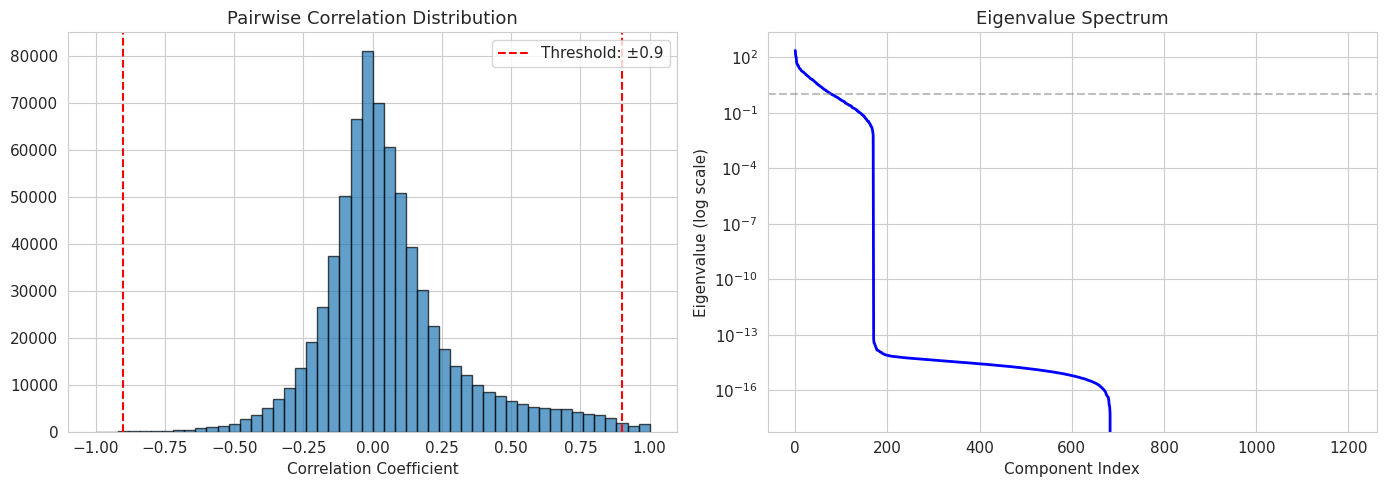

In [37]:
# Run the pipeline
pipeline = ToxicityPipeline()

# Load and preprocess data
pipeline.load_data().preprocess(apply_smote=True)

# Analyze multicollinearity
pipeline.analyze_multicollinearity()


In [39]:
# Run baseline evaluation
baseline_results = pipeline.run_baseline_evaluation(use_smote=False, verbose=True)
print("\nTop 10 Models (Baseline):")
print(baseline_results[['model', 'mcc', 'pr_auc', 'bacc', 'test_auc']].head(10))


Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Training LR_Ridge_C0.01... MCC: 0.0187
Training LR_Ridge_C0.1... MCC: -0.0195
Training LR_Ridge_C1.0... MCC: 0.0296
Training LR_Ridge_C10.0... MCC: -0.0606
Training LR_Lasso_C0.01... MCC: 0.0000 ⚠
Training LR_Lasso_C0.1... MCC: 0.0000 ⚠
Training LR_Lasso_C1.0... MCC: 0.0720
Training LR_ElasticNet... MCC: 0.0754
Training LR_Ridge_Weighted... MCC: -0.0195
Training DecisionTree_D5... MCC: 0.2010
Training DecisionTree_D10... MCC: 0.1599
Training DecisionTree_D20... MCC: 0.1599
Training RandomForest_N50... MCC: 0.1231
Training RandomForest_N100... MCC: 0.0712
Training RandomForest_N200... MCC: 0.0712
Training XGBoost... MCC: 0.1650
Training GradientBoosting... MCC: 0.1650
Training AdaBoost... MCC: 0.1168
Training ExtraTrees... MCC: 0.0712
Training SVM_LINEAR... MCC: -0.0606
Training SVM_RBF_C1.0... MCC: 0.0000 ⚠
Training SVM_RBF_C10.0... MCC: -0.1932
Training SVM_POLY_degree2... MCC: 0.0000 ⚠
Training SVM_POLY_degree3... MCC: 0.0000 ⚠
Training KNN_K3... MCC: 0.2045
Training KNN_K5... MCC: 0

/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


In [38]:
# Run with SMOTE
smote_results = pipeline.run_baseline_evaluation(use_smote=True, verbose=True)
print("\nTop 10 Models (SMOTE):")
print(smote_results[['model', 'mcc', 'pr_auc', 'bacc', 'test_auc']].head(10))

Evaluating_SMOTE:   0%|          | 0/34 [00:00<?, ?it/s]

Training LR_Ridge_C0.01... MCC: 0.0296
Training LR_Ridge_C0.1... MCC: -0.0606
Training LR_Ridge_C1.0... MCC: 0.0296
Training LR_Ridge_C10.0... MCC: -0.0606
Training LR_Lasso_C0.01... MCC: 0.0000 ⚠
Training LR_Lasso_C0.1... MCC: -0.0503
Training LR_Lasso_C1.0... MCC: 0.0296
Training LR_ElasticNet... MCC: 0.0754
Training LR_Ridge_Weighted... MCC: -0.0606
Training DecisionTree_D5... MCC: 0.3671
Training DecisionTree_D10... MCC: 0.3712
Training DecisionTree_D20... MCC: 0.3712
Training RandomForest_N50... MCC: 0.1168
Training RandomForest_N100... MCC: 0.1593
Training RandomForest_N200... MCC: 0.0720
Training XGBoost... MCC: 0.0754
Training GradientBoosting... MCC: 0.1200
Training AdaBoost... MCC: 0.1599
Training ExtraTrees... MCC: 0.1593
Training SVM_LINEAR... MCC: -0.0606
Training SVM_RBF_C1.0... MCC: 0.0296
Training SVM_RBF_C10.0... MCC: -0.1000
Training SVM_POLY_degree2... MCC: 0.1654
Training SVM_POLY_degree3... MCC: 0.2073
Training KNN_K3... MCC: 0.2297
Training KNN_K5... MCC: 0.0195
T

/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


In [40]:
# Run nested cross-validation on top models
# Select top performers from baseline
top_models = baseline_results.nlargest(10, 'mcc')['model'].tolist()
top_models += ['LR_Ridge_C0.1', 'LR_Lasso_C0.1', 'LR_ElasticNet']  # Add interpretable models
top_models = list(set(top_models))

nested_cv_results = pipeline.run_nested_cv(model_names=top_models, verbose=True)


NESTED CROSS-VALIDATION


Nested CV:   0%|          | 0/13 [00:00<?, ?it/s]


Evaluating LDA... 

ERROR:__main__:Nested CV for LDA failed: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


✗ FAILED: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Evaluating KNN_K3... ✓ MCC: -0.064 [-0.304, 0.175]

Evaluating RandomForest_N50... 

ERROR:__main__:Nested CV for RandomForest_N50 failed: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


✗ FAILED: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Evaluating LR_Ridge_C0.1... 

ERROR:__main__:Nested CV for LR_Ridge_C0.1 failed: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


✗ FAILED: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Evaluating GradientBoosting... 

KeyboardInterrupt: 

In [ ]:
# Print summary and generate visualizations
pipeline.print_summary()
pipeline.generate_visualizations()


In [ ]:
# Export results
pipeline.export_results()


In [ ]:
# Statistical comparison of top models
print("\n" + "=" * 80)
print("STATISTICAL COMPARISON (TOP 5 MODELS)")
print("=" * 80)

if 'nested_cv' in pipeline.results:
    top5 = pipeline.results['nested_cv'].head(5)
    
    for i in range(len(top5)):
        for j in range(i+1, len(top5)):
            m1, m2 = top5.iloc[i], top5.iloc[j]
            
            # Check CI overlap
            ci_overlap = (
                m1['ci_mcc_lower'] <= m2['ci_mcc_upper'] and
                m2['ci_mcc_lower'] <= m1['ci_mcc_upper']
            )
            
            print(f"\n{m1['model']} vs {m2['model']}:")
            print(f"  MCC difference: {abs(m1['mean_mcc'] - m2['mean_mcc']):.4f}")
            print(f"  95% CI overlap: {'Yes (not significant)' if ci_overlap else 'No (significant)'}")